In [1]:
%autosave 90
%matplotlib notebook

Autosaving every 90 seconds


In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def read_results(filename, new_name=None):
    with open(filename, 'rb') as f:
        results = pickle.load(f)
        results = results.dropna(subset=['auc'])
    if new_name:
        results.graph = new_name
    return results

def concat_seeds(basename, n_seeds=3):
    n_seeds = range(1, n_seeds)
    pattern = basename + "_seed{}.pkl"
    df = read_results(pattern.format(0))
    for i in n_seeds:
        df = pd.concat([df, read_results(pattern.format(i))], ignore_index=True)
    return df

def add_missing_nodes(graph_df, all_nodes_df, graph_name):
    missing = set(all_nodes_df.gene).difference(graph_df.gene)
    diff = all_nodes_df.loc[all_nodes_df.gene.isin(missing)].copy()
    diff.auc = 0.5
    diff.graph = graph_name
    return pd.concat([graph_df, diff], ignore_index=True) 

def calculate_mean(baseline, graph):
    first_degree = graph.groupby(['gene']).auc.agg(['mean', 'std'])
    full = baseline.groupby(['gene']).auc.agg(['mean', 'std'])
    meandiff = first_degree.sub(full).sort_values('mean', ascending=False)
    return meandiff
    
def plot_hist(graphs, labels, xlimits=(-.4, .3), bins=100, title=None):        
    fig, ax = plt.subplots()
    for idx, expt in enumerate(graphs):
        n1, bins1, patches1 = ax.hist(expt['mean'], range=xlimits, bins=bins, label=labels[idx], 
                                      density=0, alpha=0.6, histtype='step')
    if title is None:
        title = "First Degree Neighbors vs Full Gene Set"
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("% AUC Improvement")
    plt.legend(loc='best')
    plt.show()   


# Read dataframes

Starting with the all_nodes and compare how performance has changed due to new hyperparams

In [4]:
# Baselines
all_nodes = read_results('./all_seed0.pkl')
all_nodes_old = read_results('./old/all_1l.pkl', new_name='all_nodes_old')

all_diff = calculate_mean(all_nodes_old, all_nodes)

<IPython.core.display.Javascript object>


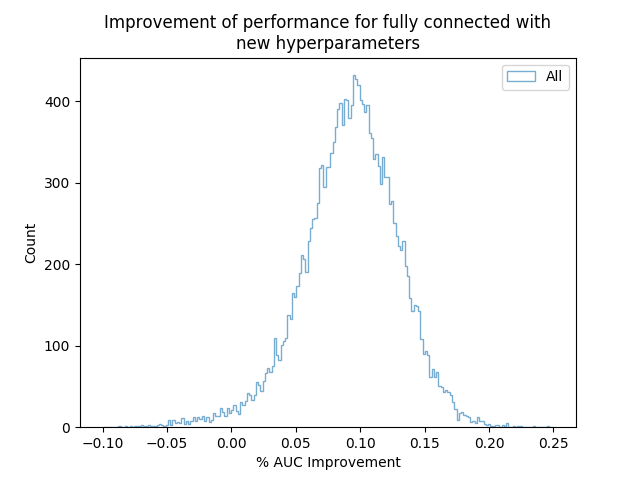

In [13]:
plot_hist(graphs=[all_diff], labels=['All'], xlimits=(-.1, .25),
         bins=200, title="Improvement of performance for fully connected with\nnew hyperparameters")

## HetIO

In [9]:
hetio = concat_seeds('hetio_all')
het = hetio.groupby('gene').auc.agg('std')

In [10]:
het.describe()

count    17308.000000
mean         0.015283
std          0.010777
min          0.000000
25%          0.007763
50%          0.013445
75%          0.020830
max          0.117777
Name: auc, dtype: float64

<IPython.core.display.Javascript object>


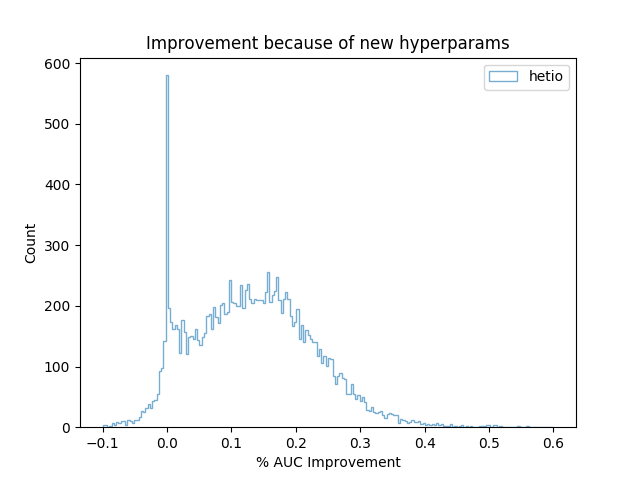

In [7]:
hetio = concat_seeds('hetio_all')
hetio_old = read_results('./old/ht_ams_elu_half.pkl', new_name='hetio_old')
hetio_gig = read_results('./old/het_gig.pkl', new_name='hetio_gig')

het_diff = calculate_mean(hetio_old, hetio)
plot_hist(graphs=[het_diff], labels=['hetio'], xlimits=(-.1, .6),
         bins=200, title='Improvement because of new hyperparams')

In [8]:
hetio = add_missing_nodes(hetio, all_nodes, 'hetio')
hetio_old = add_missing_nodes(hetio_old, all_nodes, 'hetio_old')
hetio_gig = add_missing_nodes(hetio_gig, all_nodes, 'hetio_gig')

hetio.name = 'hetio'
hetio_old.name = 'hetio_old'
hetio_gig.name ='hetio_gig'

hets = [hetio, hetio_old, hetio_gig]

### Comparing to new results (only 1 trial)

<IPython.core.display.Javascript object>


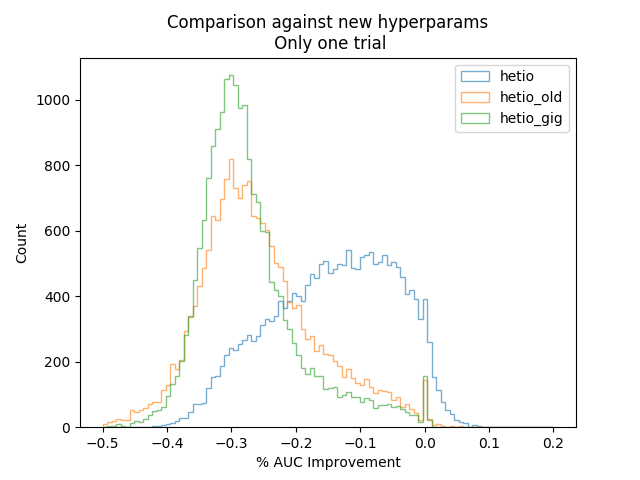

In [9]:
het_means, het_labels = [], []
for df in hets:
    het_means.append(calculate_mean(baseline=all_nodes, graph=df))
    het_labels.append(df.name)

plot_hist(graphs=het_means, labels=het_labels, xlimits=(-.5, .2),
         bins=100, title='Comparison against new hyperparams\n Only one trial')

<IPython.core.display.Javascript object>


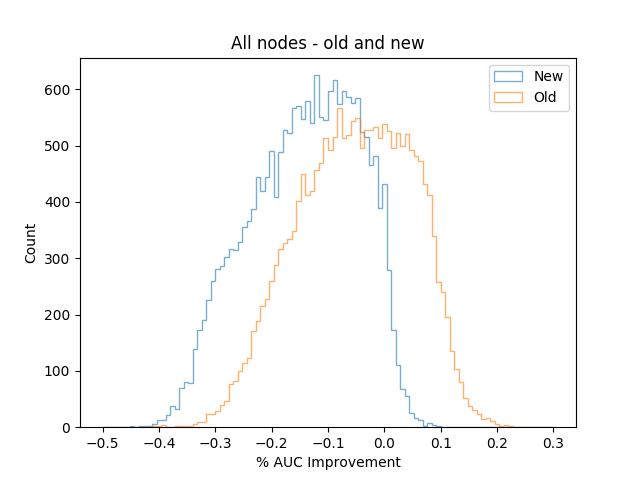

In [10]:
_het_old_all = calculate_mean(baseline=all_nodes_old, graph=hetio)
plot_hist(graphs=[het_means[0], _het_old_all], labels=['New', 'Old'], xlimits=(-.5, .3),
         bins=100, title='All nodes - old and new')

## FunCoup old

In [11]:
funcoup = read_results('./old/fc_sgi.pkl')
#funcoup = add_missing_nodes(funcoup, all_nodes, 'funcoup')

<IPython.core.display.Javascript object>


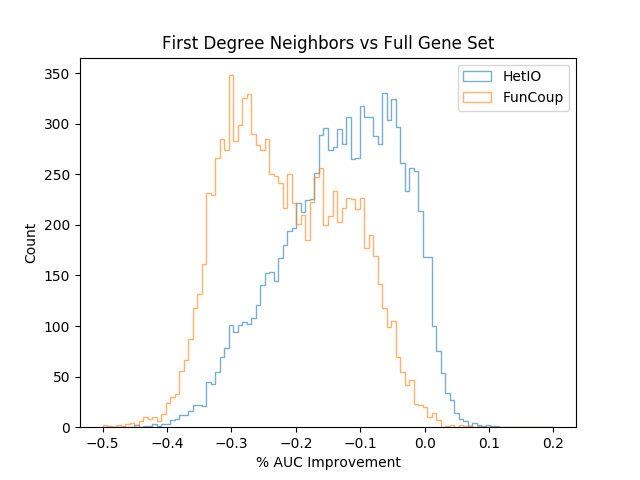

In [12]:
fc_diff = calculate_mean(baseline=all_nodes, graph=funcoup)
fc_diff = fc_diff.dropna(subset=['mean'])

inter = hetio.loc[hetio.gene.isin(funcoup.gene)]
inter_mean = calculate_mean(baseline=all_nodes, graph=inter)
inter_mean = inter_mean.dropna(subset=['mean'])

plot_hist(graphs=[inter_mean, fc_diff], labels=['HetIO', 'FunCoup'], xlimits=(-.5, .2),
         bins=100)